In [19]:
from generate_trajectory.generate_trajectory import *
from generate_trajectory.plot_trajectory import *

ModuleNotFoundError: No module named 'uav_trajectory'

In [16]:
from curves_to_trajectory import curves

def generate_test_data():
    fx, fy = curves.circle_facing_constant((1, 0), 10)
    print("Generating position data")
    generate_position_data(fx=fx, fy=fy,
                           domain=(0, 10),
                           output='pos.csv')
    print("Generating trajectory")
    traj = generate_trajectory_from_file('pos.csv')
    traj.savecsv('traj.csv')
    print("Plotting")
    plot(traj)

Generating position data


NameError: name 'generate_position_data' is not defined

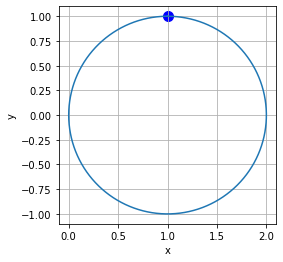

In [15]:
generate_test_data()